In [116]:
import numpy as np
import copy
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['legend.fontsize'] = 15

### We define a Gaussian mixture model as the spatial probability density function
from scipy.stats import multivariate_normal as mvn
from scipy.integrate import solve_bvp # import the TPBVP solver

mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3


# Define the Gaussian-mixture density function here
def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3)

In [117]:
### We are going to use 10 coefficients per dimension --- so 100 index vectors in total

num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # this is the set of all index vectors
print('First 5 index vectors: ')
print(ks[:5, :])

# define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99  # the resolution of the grids

# Compute the coefficients
coefficients = np.zeros(ks.shape[0])  # number of coefficients matches the number of index vectors
for i, k_vec in enumerate(ks):
    # step 1: evaluate the fourier basis function over all the grid cells
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  # we use NumPy's broadcasting feature to simplify computation
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)  # normalization term
    fk_vals /= hk

    # step 2: evaluate the spatial probabilty density function over all the grid cells
    pdf_vals = pdf(grids)  # this can computed ahead of the time

    # step 3: approximate the integral through the Riemann sum for the coefficient
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    coefficients[i] = phik

print('First 5 coefficients: ', coefficients[:5])

First 5 index vectors: 
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]]
First 5 coefficients:  [ 0.9898  0.0799 -0.7756 -0.063  -0.0555]


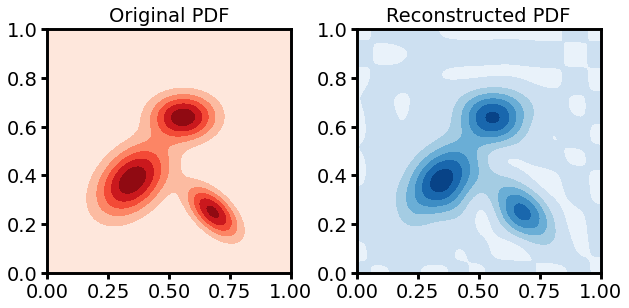

In [118]:
### We can verify the correctness of the coefficients by reconstructing the probability
### density function through the coefficients

pdf_recon = np.zeros(grids.shape[0])
for i, (phik, k_vec) in enumerate(zip(coefficients, ks)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk

    pdf_recon += phik * fk_vals

pdf_gt = pdf(grids)  # ground truth density function

# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_gt.reshape(grids_x.shape), cmap='Reds')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Reconstructed PDF')
ax.contourf(grids_x, grids_y, pdf_recon.reshape(grids_x.shape), cmap='Blues')

plt.show()
plt.close()

First 5 coefficients:  [ 0.99    0.1249 -0.7205 -0.126  -0.0553]


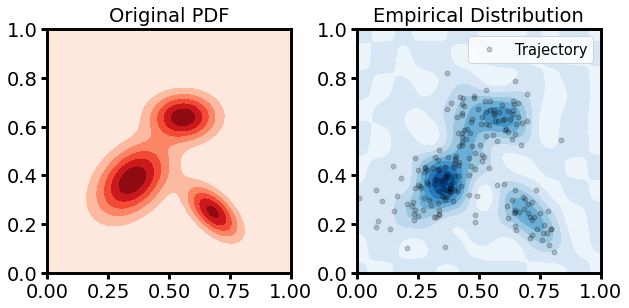

ergodic metric:  0.016025826174807727


In [119]:
# define the dynamics
def dyn(st):
    mixture_category = np.where(np.random.multinomial(1, [w1, w2, w3])==1.0)[0][0]
    if mixture_category == 0:
        st_new = mvn.rvs(mean1, cov1)
    elif mixture_category == 1:
        st_new = mvn.rvs(mean2, cov2)
    else:
        st_new = mvn.rvs(mean3, cov3)
    return st_new


# simulate the trajectory
dt = 0.1
tsteps = 200
st = np.ones(2) * 0.5
s_traj = []
for t in range(tsteps):
    st_new = dyn(st)
    s_traj.append(st_new)
    st = st_new.copy()
s_traj = np.array(s_traj)

# compute the coefficient of the trajectory
traj_coefficients = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    # step 1: evaluate the basis function over the trajectory
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * s_traj), axis=1)
    hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
    fk_vals /= hk

    # step 2: approximate the integral through the Riemann sum for the coefficient
    ck = np.sum(fk_vals) * dt / (tsteps * dt)
    traj_coefficients[i] = ck

print('First 5 coefficients: ', traj_coefficients[:5])

phi_recon = np.zeros(grids.shape[0])
for i, (ck, k_vec) in enumerate(zip(traj_coefficients, ks)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk

    phi_recon += ck * fk_vals

pdf_gt = pdf(grids)  # ground truth density function

# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_gt.reshape(grids_x.shape), cmap='Reds')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Empirical Distribution')
ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax.plot(s_traj[:,0], s_traj[:,1], linestyle='', marker='o', color='k', alpha=0.2, label='Trajectory')
ax.legend(loc=1)

plt.show()
plt.close()

# Finally, we compute the erogdic metric
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coefficients))
print('ergodic metric: ', erg_metric)

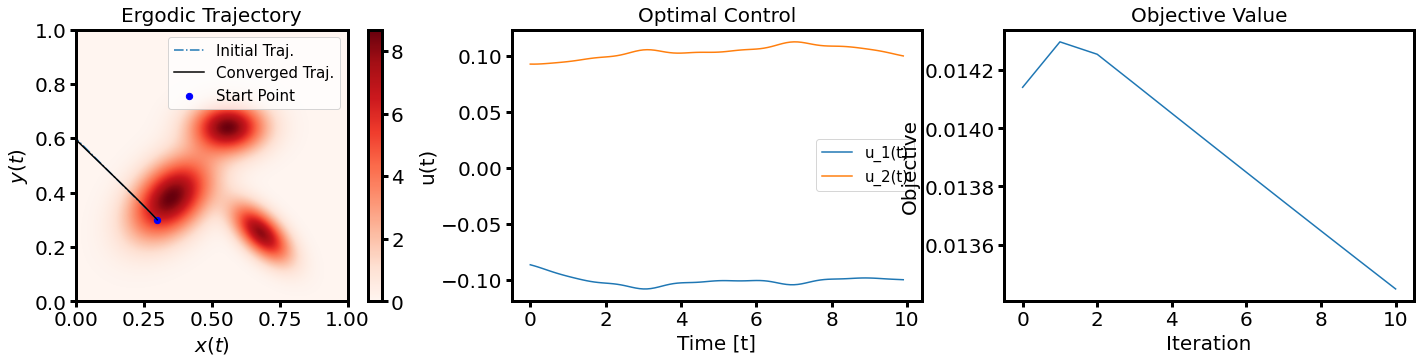

In [133]:
# Problem 1

from scipy.stats import multivariate_normal as mvn


### define parameters
dt = 0.1
x0 = np.array([0.3, 0.3])
# tsteps = 63
T = 10
tlist = np.arange(0, T, dt)
tsteps = tlist.shape[0]
init_u_traj = np.tile(np.array([-0.1, 0.1]), reps=(tsteps,1))

# Q_x = np.diag([10.0, 10.0, 2.0])
R_u = np.diag([0.0, 0.0])
P1 = np.diag([2.0, 2.0])

Q_z=np.diag([0.001, 0.001])
R_v=np.diag([0.01, 0.01])

w1=0.5
mu1=np.array([0.35, 0.38])
cov1=np.array([[0.01, 0.004], [0.004, 0.01]])
w2=0.2
mu2=np.array([0.68, 0.25])
cov2=np.array([[0.005, -0.003], [-0.003, 0.005]])
w3=0.3
mu3=np.array([0.56, 0.64])
cov3=np.array([[0.008, 0.0], [0.0, 0.004]])

weights = np.array([w1, w2, w3])
means = np.array([mu1, mu2, mu3])
covs = np.array([cov1, cov2, cov3])

N_grid = 1000
N = N_grid + 1
K_per_dim = 10

dx = dy = 1.0 / N_grid

dists = []
for mu, cov in zip(means, covs):
    dist = mvn(mean=mu, cov=cov)
    dists.append(dist)

kdim_x = np.arange(K_per_dim)
kdim_y = np.arange(K_per_dim)

ks_x, ks_y = np.meshgrid(kdim_x, kdim_y)
ks_xy = np.array([ks_x.ravel(), ks_y.ravel()]).T

q=0.01

phi_list = np.empty(0)
fk_list = np.empty(0)
h_list = np.empty(0)
c_list = np.empty(0)
f_traj = np.empty(0)
lam_list = np.empty(0)
dfkdxdt_list = np.empty(0)

def pdf(x, weights, dists, dx, dy):
    result = np.zeros(shape=x.shape[0])

    for w, dist in zip(weights, dists):
        result += w * dist.pdf(x)

    result /= np.sum(result * dx * dy)
    return result


def dyn_random(_, weights, dists):
    ind_dist = np.random.choice(a=np.arange(len(weights)), size=1, p=weights)[0]
    dist = dists[ind_dist]
    return dist.rvs()


def xdot(_, ut):
    return ut


def next_state(xt, ut, dt):
    k1 = dt * xdot(xt, ut)
    k2 = dt * xdot(xt + k1 / 2.0, ut)
    k3 = dt * xdot(xt + k2 / 2.0, ut)
    k4 = dt * xdot(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new


def dyn(xt, ut):
    xdot = copy.deepcopy(ut)
    return xdot


def get_A(t, xt, ut):
    A = np.zeros((2,2))
    # theta = xt[2]
    # u1 = ut[0]
    # A[0, 2] = -np.sin(theta) * u1
    # A[1, 2] = np.cos(theta) * u1
    return A


def get_B(t, xt, ut):
    B = np.eye(2)
    # theta = xt[2]
    # B[0, 0] = np.cos(theta)
    # B[1, 0] = np.sin(theta)
    # B[2, 1] = 1
    return B


def get_xd(t):
    xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])
    return xd

def step(xt, ut):
    # xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    k1 = dt * dyn(xt, ut)
    k2 = dt * dyn(xt + k1 / 2.0, ut)
    k3 = dt * dyn(xt + k2 / 2.0, ut)
    k4 = dt * dyn(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new


def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps+1, x0.shape[0]))
    x_traj[0, :] = x0
    xt = copy.deepcopy(x0)
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t+1] = copy.deepcopy(xt_new)
        xt = copy.deepcopy(xt_new)
    return x_traj


# def loss(t, xt, ut):
#     xd = np.array([2.0*t / np.pi, 0.0, np.pi/2.0])  # desired system state at time t

#     x_diff = xt - xd
#     x_loss = x_diff.T @ Q_x @ x_diff
#     u_loss = ut.T @ R_u @ ut

#     return x_loss + u_loss


def dldx(t, xt, ut):
    # xd = np.array([2.0*t / np.pi, 0.0, np.pi/2.0])
    # qlist = np.diag(Q_x)
    # # dvec = np.zeros(3)  # replace this
    # dx = xt - xd
    # dvec = 2 * qlist * dx

    t_ind = np.where(tlist == t)[0][0]
    dvec = np.zeros(2)  # replace this
    for lam_k, ck, phi_k, hk, k_vec, fk_traj, dfkdxdt in zip(
        lam_list, c_list, phi_list, h_list, ks_xy, f_traj, dfkdxdt_list
    ):

        fk_t = fk_traj[t_ind]

        dfkdx = (-1.0 / hk * (
                k_vec
                * np.pi
                * np.sin(k_vec * np.pi * xt)
                * np.cos(k_vec[::-1] * np.pi * xt[::-1])))

        dvec += q * lam_k * (2 * (ck - phi_k) * 1 / T * dfkdx)

    return dvec


def dldu(t, xt, ut):
    dvec = np.zeros(2)  # replace this
    rlist = np.diag(R_u)
    dvec = rlist * ut
    return dvec

def J_xu(x_traj, u_traj):
        J_val = 0

        # for xt, ut, t in zip(x_traj[:, :], u_traj, tlist):
        #     l_val = loss(t, xt, ut)
        #     J_val += l_val

        J_val += q * np.sum(lam_list * np.square(c_list - phi_list))

        for ut in u_traj:
            J_val += ut.T @ R_u @ ut * dt

        return J_val

def ilqr_iter(x0, u_traj):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    tlist = np.arange(0, T, dt)
    tsteps = tlist.shape[0]

    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)


    c_list = np.zeros(ks_xy.shape[0])
    f_traj = np.zeros([ks_xy.shape[0], x_traj.shape[0]])

    for i, (k_vec, hk) in enumerate(zip(ks_xy, h_list)):
        fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * x_traj), axis=1)
        dfkdxdt = np.zeros(2)

        hk = h_list[i]
        fk_vals /= hk

        ck = np.sum(fk_vals) * dt / T

        for xt in x_traj:
            dfkdx = (
                -1
                / hk
                * k_vec
                * np.sin(k_vec * np.pi * xt)
                * np.cos(k_vec[::-1] * np.pi * xt[::-1])
            )
            dfkdxdt += dfkdx * dt

        # print(fk_vals.shape)
        # fk_vals_gt = fk_list[i, :]

        dfkdxdt_list[i, :] = copy.deepcopy(dfkdxdt)
        f_traj[i, :] = fk_vals
        c_list[i] = ck

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 2, 2))
    B_list = np.zeros((tsteps, 2, 2))
    a_list = np.zeros((tsteps, 2))
    b_list = np.zeros((tsteps, 2))

    for t_idx, t in np.ndenumerate(tlist):
        # t = t_idx * dt
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
        b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

    # xd_T = np.array([2.0*(tsteps-1)*dt / np.pi, 0.0, np.pi/2.0])  # desired terminal state
    # p1 = 2 * np.diag(P1) * (x_traj[-1,:] - xd_T)
    xd_T = get_xd(tlist[-1])  # desired terminal state
    xT = x_traj[-1, :]
    xT_2 = x_traj[int(x_traj.shape[0] / 2), :]
        
    plist = np.diag(P1)
    # p1 = np.zeros(3)  # replace it to be the terminal condition p(T)

    p1 = 2 * plist * (xT - mu2) * (xT_2 - mu3)
    # p1 = plist * xT
    p1 = np.zeros(2)

    def zp_dyn(t, zp):
        zt = zp[:2]
        pt = zp[2:]
        t_idx = (t/dt).astype(int)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        M_11 = At
        M_12 = np.zeros((2,2))  # DONT replace this
        M_21 = np.zeros((2,2))  # DONT replace this
        M_22 = -1*At.T
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        m_1 = -Bt @ np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        m_2 = -at - zt @ Q_z
        dyn_vec = np.hstack([m_1, m_2])

        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((4, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        # return np.zeros(6)  # replace this
        z0 = zp_0[:2]
        p0 = zp_0[2:]

        zT = zp_T[:2]
        pT = zp_T[2:]

        bc = np.zeros(4)
        bc[:2] = z0
        bc[2:] = np.abs(pT - p1)
        # print(bc)

        return bc

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
    tlist = np.arange(tsteps) * dt
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((4,tsteps)),
        max_nodes=100)
    zp_traj = res.sol(tlist).T

    z_traj = zp_traj[:,:2]
    p_traj = zp_traj[:,2:]

    v_traj = np.zeros((tsteps, 2))
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]

        # vt = np.zeros(2)  # replace this
        vt = -1*np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        v_traj[_i] = vt

    return v_traj, c_list


L_list = np.array([1, 1], dtype="float")

grid_x, grid_y = np.meshgrid(
    np.linspace(0, L_list[0], N),
    np.linspace(0, L_list[1], N),
)
grids_xy = np.array([grid_x.ravel(), grid_y.ravel()]).T
pdf_gt = pdf(
    x=grids_xy,
    weights=weights,
    dists=dists,
    dx=dx,
    dy=dy,
)

phi_list = np.zeros(ks_xy.shape[0])
fk_list = np.zeros(shape=(ks_xy.shape[0], N**2))
h_list = np.zeros(ks_xy.shape[0])

for i, k_vec in enumerate(ks_xy):
    fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * grids_xy), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk
    phi_k = np.sum(pdf_gt * fk_vals * dx * dy)

    h_list[i] = hk
    fk_list[i, :] = fk_vals
    phi_list[i] = phi_k

c_list = np.zeros(ks_xy.shape[0])
f_traj = np.zeros((ks_xy.shape[0], tsteps))
lam_list = np.power(1.0 + np.linalg.norm(ks_xy, axis=1), -3.0 / 2.0)
dfkdxdt_list = np.zeros((ks_xy.shape[0], 2))

# Start iLQR iterations here

u_traj = init_u_traj.copy()
# j_array = np.zeros((10, 2))
j_array = np.array([J_xu(traj_sim(x0, u_traj), u_traj)])
x_traj_init = traj_sim(x0, u_traj)
for iter in range(10):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)

    # # visualize the current trajectory
    # fig, ax = plt.subplots(1, 1)
    # ax.set_title('Iter: {:d}'.format(iter))
    # ax.set_aspect('equal')
    # ax.set_xlim(-0.2, 4.2)
    # ax.set_ylim(-0.2, 2.2)
    # ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0')
    # plt.show()
    # plt.close()

    # get descent direction
    v_traj, c_list = ilqr_iter(x0, u_traj)

    # Armijo line search parameters
    gamma = 0.001  # initial step size
    alpha = 1e-04
    beta = 0.5

    ### Implement Armijo line search here to update step size gamma
    while J_xu(x_traj, u_traj + gamma * v_traj) > J_xu(x_traj, u_traj) + alpha * gamma * np.abs(np.trace(-v_traj.T @ v_traj)):
        gamma *= beta

    # j_array[iter, 0] = iter
    # j_array[iter, 1] = J_xu(x_traj, u_traj + gamma * v_traj)
    j_array = np.hstack([j_array, J_xu(x_traj, u_traj)])
    # update control for the next iteration
    u_traj += gamma * v_traj


# # visualize the current trajectory
# fig, ax = plt.subplots(3, 3, figsize=(15, 9))
# ax[0][0].set_title('State Trajectories')
# ax[0][0].set_aspect('equal')
# ax[0][0].set_xlim(-0.2, 4.2)
# ax[0][0].set_ylim(-0.2, 2.2)
# ax[0][0].plot(x_traj_init[:,0], x_traj_init[:,1], linestyle='--', color='C0', label='Initial Trajectory')
# ax[0][0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0', label='Converged Trajectory')
# ax[0][0].legend()

# # Visualize the J over time
# ax[0][1].set_title('Optimal Control')
# ax[0][1].set_aspect('auto')
# ax[0][1].set_xlim(-0.2, 7.0)
# ax[0][1].set_ylim(-5.0, 5.0)
# ax[0][1].plot(tlist, u_traj[:,0], linestyle='-', color='b', label='u1(t)')
# ax[0][1].plot(tlist, u_traj[:,1], linestyle='-', color='orange', label='u2(t)')
# ax[0][1].legend()

# # Visualize the J over time
# ax[0][2].set_title('Objective Value per iteration')
# ax[0][2].set_aspect('auto')
# ax[0][2].set_xlim(-0.2, 10.2)
# ax[0][2].plot(j_array[:,0], j_array[:,1], linestyle='-', color='C0', label='Final')

fig, axs = plt.subplots(1, 3, figsize=(25, 5))

axs[0].set_title("Ergodic Trajectory")
axs[0].set_xlabel(r"$x(t)$")
axs[0].set_ylabel(r"$y(t)$")
cax = axs[0].imshow(
    pdf_gt.reshape(N, N),
    origin="lower",
    cmap="Reds",
    extent=[0, 1, 0, 1],
)
axs[0].plot(
    x_traj_init[:, 0],
    x_traj_init[:, 1],
    linestyle="-.",
    label="Initial Traj.",
)
axs[0].plot(
    x_traj[:, 0],
    x_traj[:, 1],
    linestyle="-",
    color="k",
    label="Converged Traj.",
)
axs[0].scatter(x0[0], x0[1], color="b", s=40, label="Start Point")
fig.colorbar(cax, ax=axs[0])
# axs[0].plot(
#     xd_traj[:, 0],
#     xd_traj[:, 1],
#     linestyle="--",
#     label="Desired Trajectory",
# )
# axs[0].set_aspect("equal")

axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].set_title("Optimal Control")
axs[1].set_xlabel("Time [t]")
axs[1].set_ylabel("u(t)")
axs[1].plot(tlist, u_traj[:, 0], label="u_1(t)")
axs[1].plot(tlist, u_traj[:, 1], label="u_2(t)")
axs[1].legend()

axs[2].set_title("Objective Value")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Objective")
axs[2].plot(j_array)


In [ ]:
phi_list = np.empty(0)
fk_list = np.empty(0)
h_list = np.empty(0)
c_list = np.empty(0)
f_traj = np.empty(0)
lam_list = np.empty(0)
dfkdxdt_list = np.empty(0)

# RESULTS_DIR = os.path.join(os.path.dirname(os.path.abspath(__file__)), "Results")


def pdf(x, weights, dists, dx, dy):
    result = np.zeros(shape=x.shape[0])

    for w, dist in zip(weights, dists):
        result += w * dist.pdf(x)

    result /= np.sum(result * dx * dy)
    return result


def dyn_random(_, weights, dists):
    ind_dist = np.random.choice(a=np.arange(len(weights)), size=1, p=weights)[0]
    # print(ind_dist)
    dist = dists[ind_dist]
    return dist.rvs()


def xdot(_, ut):
    return ut


def next_state(xt, ut, dt):
    k1 = dt * xdot(xt, ut)
    k2 = dt * xdot(xt + k1 / 2.0, ut)
    k3 = dt * xdot(xt + k2 / 2.0, ut)
    k4 = dt * xdot(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new


# def barr(x_traj):
#     x_traj_barr = np.zeros_like(x_traj)

#     for xt in x_traj:
#         x1, x2 = xt
#         x1_barr = min(0, x-0)**2+max()


# def main_p2(
dt=0.1
T=10
# init_u_traj=np.zeros(shape=(63, 2)),
# x0=np.array([0.0, 0.0, np.pi / 2.0]),
x0=np.array([0.3, 0.3])
# Q_x=np.diag([0.01, 0.01, 2.0]),
q=0.01
R_u=np.diag([0.0, 0.0])
# P1=np.diag([20.0, 20.0, 5.0]),
P1=np.diag([2.0, 2.0])
# Q_z=np.diag([5.0, 5.0, 1.0]),
Q_z=np.diag([0.001, 0.001, 0.001, 0.001])
R_v=np.diag([0.01, 0.01, 0.01, 0.01])
w1=0.5
mu1=np.array([0.35, 0.38])
cov1=np.array([[0.01, 0.004], [0.004, 0.01]])
w2=0.2
mu2=np.array([0.68, 0.25])
cov2=np.array([[0.005, -0.003], [-0.003, 0.005]])
w3=0.3
mu3=np.array([0.56, 0.64])
cov3=np.array([[0.008, 0.0], [0.0, 0.004]])
init_u_traj=np.tile(np.array([-0.1, 0.1]), reps=100)
N_grid=1000
K_per_dim=10
gamma_0=0.001
max_iter=100
fig_filename="example.png"
multiplier=1
# ):
tlist = np.arange(0, T, dt)
tsteps = tlist.shape[0]

weights = np.array([w1, w2, w3])
means = np.array([mu1, mu2, mu3])
covs = np.array([cov1, cov2, cov3])

N = N_grid + 1

dx = dy = 1.0 / N_grid

dists = []
for mu, cov in zip(means, covs):
    dist = mvn(mean=mu, cov=cov)
    dists.append(dist)

kdim_x = np.arange(K_per_dim)
kdim_y = np.arange(K_per_dim)

ks_x, ks_y = np.meshgrid(kdim_x, kdim_y)
ks_xy = np.array([ks_x.ravel(), ks_y.ravel()]).T

L_list = np.array([1, 1], dtype="float")

grid_x, grid_y = np.meshgrid(
    np.linspace(0, L_list[0], N),
    np.linspace(0, L_list[1], N),
)
grids_xy = np.array([grid_x.ravel(), grid_y.ravel()]).T
pdf_gt = pdf(
    x=grids_xy,
    weights=weights,
    dists=dists,
    dx=dx,
    dy=dy,
)

phi_list = np.zeros(ks_xy.shape[0])
fk_list = np.zeros(shape=(ks_xy.shape[0], N**2))
h_list = np.zeros(ks_xy.shape[0])

for i, k_vec in enumerate(ks_xy):
    fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * grids_xy), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk
    phi_k = np.sum(pdf_gt * fk_vals * dx * dy)

    h_list[i] = hk
    fk_list[i, :] = fk_vals
    phi_list[i] = phi_k

c_list = np.zeros(ks_xy.shape[0])
f_traj = np.zeros((ks_xy.shape[0], tsteps))
lam_list = np.power(1.0 + np.linalg.norm(ks_xy, axis=1), -3.0 / 2.0)
dfkdxdt_list = np.zeros((ks_xy.shape[0], 2))

def dyn(xt, ut):
    # xdot = np.zeros(3)  # replace this
    # theta = xt[2]
    # u1 = ut[0]
    # u2 = ut[1]
    # x1dot = np.cos(theta) * u1
    # x2dot = np.sin(theta) * u1
    # x3dot = u2
    x1dot = xt[2]
    x2dot = xt[3]
    x1ddot = ut[0]
    x2ddot = ut[1]

    # xdot = np.array([x1dot, x2dot, x3dot])
    # xdot = copy.deepcopy(ut)
    xdot = np.array([x1dot, x2dot, x1ddot, x2ddot])
    return xdot

def get_A(t, xt, ut):
    # theta = xt[2]
    # u1 = ut[0]
    # A_mat = np.zeros((2, 2))  # replace this
    A_mat = np.zeros((4, 4))
    A_mat[0, 2] = 1
    A_mat[1, 3] = 1
    # A_mat[0, 2] = -np.sin(theta) * u1
    # A_mat[1, 2] = np.cos(theta) * u1
    return A_mat

def get_B(t, xt, ut):
    # theta = xt[2]
    B_mat = np.zeros((4, 2))  # replace this
    B_mat[2, 0] = 1
    B_mat[3, 1] = 1
    # B_mat = np.eye(2)
    # B_mat[0, 0] = np.cos(theta)
    # B_mat[1, 0] = np.sin(theta)
    # B_mat[2, 1] = 1
    return B_mat

def get_xd(t):
    xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])
    return xd

def step(xt, ut):
    # xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    k1 = dt * dyn(xt, ut)
    k2 = dt * dyn(xt + k1 / 2.0, ut)
    k3 = dt * dyn(xt + k2 / 2.0, ut)
    k4 = dt * dyn(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new

def traj_sim(x0, ulist):
    # tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps + 1, x0.shape[0]))
    x_traj[0, :] = x0
    xt = copy.deepcopy(x0)
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t + 1] = copy.deepcopy(xt_new)
        xt = copy.deepcopy(xt_new)
    return x_traj

# def loss(t, xt, ut):
#     # xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])  # desired system state at time t
#     xd = get_xd(t)

#     x_diff = xt - xd
#     # x_loss = 0.0  # replace this
#     x_loss = x_diff.T @ Q_x @ x_diff
#     # u_loss = 0.0  # replace this
#     u_loss = ut.T @ R_u @ ut

#     return x_loss + u_loss

def dldx(t, xt, ut):
    # xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])
    # xd = get_xd(t)
    # qlist = np.diag(Q_x)
    t_ind = np.where(tlist == t)[0][0]
    dvec = np.zeros(2)  # replace this
    for lam_k, ck, phi_k, hk, k_vec, fk_traj, dfkdxdt in zip(
        lam_list, c_list, phi_list, h_list, ks_xy, f_traj, dfkdxdt_list
    ):
        # ax_val
        # k1, k2 = k_vec
        # d_fk = np.zeros(2)
        # for xt in x_traj:
        fk_t = fk_traj[t_ind]
        # dfkdxdt = dfkdxdt_list
        # print(dfkdxdt)
        dfkdx = (
            -1.0
            / hk
            * (
                k_vec
                * np.pi
                * np.sin(k_vec * np.pi * xt[:2])
                * np.cos(k_vec[::-1] * np.pi * xt[1::-1])
            )
        )

        # dvec += lam_k / (T**2) * (dfkdx * ck * T - 2 * T * dfkdx * phi_k)
        # dvec += lam_k / (T**2) * (fk_t * dfkdxdt)
        dvec += q * lam_k * (2 * (ck - phi_k) * 1 / T * dfkdx)

    # dx = xt - xd
    # dvec = 2 * qlist * dx
    return np.append(dvec, [0, 0])

def dldu(t, xt, ut):
    dvec = np.zeros(2)  # replace this
    rlist = np.diag(R_u)
    dvec = rlist * ut
    return dvec

def func_J(x_traj, u_traj):
    J_val = 0

    # print(c_list)
    J_val += q * np.sum(lam_list * np.square(c_list - phi_list))
    # print(u_traj.T @ R_u @ u_traj)
    for ut in u_traj:
        # print(ut)
        J_val += ut.T @ R_u @ ut * dt
    # for xt, ut, t in zip(x_traj[:, :], u_traj, tlist):
    #     l_val = loss(t, xt, ut)
    #     J_val += l_val

    # xd_T = get_xd(tlist[-1])
    # xT = x_traj[-1]
    # dx_T = xT - xd_T

    # J_val += dx_T.T @ P1 @ dx_T

    return J_val

def ilqr_iter(x0, u_traj):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    c_list = np.zeros(ks_xy.shape[0])
    f_traj = np.zeros([ks_xy.shape[0], x_traj.shape[0]])
    for i, (k_vec, hk) in enumerate(zip(ks_xy, h_list)):
        fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * x_traj[:, :2]), axis=1)
        dfkdxdt = np.zeros(2)

        hk = h_list[i]
        fk_vals /= hk

        ck = np.sum(fk_vals) * dt / T

        for xt in x_traj:
            dfkdx = (
                -1
                / hk
                * k_vec
                * np.sin(k_vec * np.pi * xt[:2])
                * np.cos(k_vec[::-1] * np.pi * xt[1::-1])
            )
            dfkdxdt += dfkdx * dt

        # print(fk_vals.shape)
        # fk_vals_gt = fk_list[i, :]

        dfkdxdt_list[i, :] = copy.deepcopy(dfkdxdt)
        f_traj[i, :] = fk_vals
        c_list[i] = ck

    # print("in loop: ", c_list)
    # print(dfkdxdt_list)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 4, 4))
    B_list = np.zeros((tsteps, 4, 2))
    a_list = np.zeros((tsteps, 4))
    b_list = np.zeros((tsteps, 2))
    for t_idx, t in np.ndenumerate(tlist):
        # t = t_idx * dt
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
        b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

    xd_T = get_xd(tlist[-1])  # desired terminal state
    xT = x_traj[-1, :]
    xT_2 = x_traj[int(x_traj.shape[0] / 2), :]

    plist = np.diag(P1)
    # p1 = np.zeros(3)  # replace it to be the terminal condition p(T)

    # p1 = 2 * plist * (xT - mu2) * (xT_2 - mu3)
    # p1 = plist * xT
    p1 = np.zeros(4)

    def zp_dyn(t, zp):
        zt = zp[:4]
        pt = zp[4:]

        t_idx = int(t / dt)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        # M_11 = np.zeros((3,3))  # replace this
        M_11 = At
        M_12 = np.zeros((4, 4))  # replace this
        M_21 = np.zeros((4, 4))  # replace this
        # M_22 = np.zeros((3,3))  # replace this
        M_22 = -At.T
        dyn_mat = np.block([[M_11, M_12], [M_21, M_22]])

        # m_1 = np.zeros(3)  # replace this
        m_1 = -Bt @ np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        # m_2 = np.zeros(3)  # replace this
        m_2 = -at - zt @ Q_z
        dyn_vec = np.hstack([m_1, m_2])

        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((8, list_len))
        for _i in range(list_len):
            zp_dot_list[:, _i] = zp_dyn(t_list[_i], zp_list[:, _i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        # return np.zeros(6)  # replace this
        z0 = zp_0[:4]
        p0 = zp_0[4:]

        zT = zp_T[:4]
        pT = zp_T[4:]

        bc = np.zeros(8)
        bc[:4] = z0
        bc[4:] = np.abs(pT - p1)
        # print(bc)

        return bc

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
    res = solve_bvp(
        zp_dyn_list,
        zp_bc,
        tlist,
        np.zeros(shape=(8, tsteps)),
        verbose=1,
        max_nodes=100,
    )
    # zp_traj = np.zeros(shape=(tsteps, 6))
    # # print(res.x.shape)

    # for i in range(6):
    #     f = sitr.interp1d(res.x, res.y.T[:, i])
    #     zp_traj[:, i] = f(tlist)
    zp_traj = res.sol(tlist).T

    # print(zp_traj)

    z_traj = zp_traj[:, :4]
    p_traj = zp_traj[:, 4:]

    v_traj = np.zeros((tsteps, 2))
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]

        # vt = np.zeros(2)  # replace this
        vt = -np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        v_traj[_i, :] = vt

    return v_traj, c_list

# Start iLQR iterations here

# u_traj = init_u_traj.copy()
u_traj = copy.deepcopy(init_u_traj)
Jlist = np.array([func_J(traj_sim(x0, u_traj), u_traj)])

for iter in range(max_iter * multiplier):
    print(f"Iteration {iter} ...")
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)

    # get descent direction

    # print("before: ", c_list)
    v_traj, c_list = ilqr_iter(x0, u_traj)
    # print("after: ", c_list)
    # print(v_traj)

    # Armijo line search parameters
    gamma = copy.deepcopy(gamma_0)  # initial step size
    alpha = 1e-4
    beta = 0.5

    # print(-v_traj.T @ v_traj)

    ### Implement Armijo line search here to update step size gamma
    while func_J(x_traj, u_traj + gamma * v_traj) > func_J(
        x_traj, u_traj
    ) + alpha * gamma * np.abs(np.trace(-v_traj.T @ v_traj)):
        gamma *= beta

    # gamma = 0

    # update control for the next iteration
    u_traj += gamma * v_traj
    if iter % multiplier == multiplier - 1:
        Jlist = np.hstack([Jlist, func_J(x_traj, u_traj)])
        print(f"Gamma = {gamma}, J = {Jlist[-1]}")

    # if gamma < 1e-5:
    #     break

# print(Jlist)
init_x_traj = traj_sim(x0, init_u_traj)
# xd_traj = np.zeros(shape=(tsteps, x0.shape[0]))

# for i in range(tsteps):
#     xd_traj[i, :] = get_xd(tlist[i])

# print(x_traj.shape, u_traj.shape)
# print(xd_traj)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("State Trajectory")
axs[0].set_xlabel(r"$x(t)$")
axs[0].set_ylabel(r"$y(t)$")
cax = axs[0].imshow(
    pdf_gt.reshape(N, N),
    origin="lower",
    cmap="Reds",
    extent=[0, 1, 0, 1],
)
axs[0].plot(
    init_x_traj[:, 0],
    init_x_traj[:, 1],
    linestyle="-.",
    label="Initial Trajectory",
)
axs[0].plot(
    x_traj[:, 0],
    x_traj[:, 1],
    linestyle="-",
    color="k",
    label="Converged Trajectory",
)
axs[0].scatter(x0[0], x0[1], color="b", s=40, label="Starting Point")
fig.colorbar(cax, ax=axs[0])
# axs[0].plot(
#     xd_traj[:, 0],
#     xd_traj[:, 1],
#     linestyle="--",
#     label="Desired Trajectory",
# )
# axs[0].set_aspect("equal")
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].set_title("Optimal Control")
axs[1].set_xlabel(r"Time $[t]$")
axs[1].set_ylabel(r"$\vec{u}(t)$")
axs[1].plot(tlist, u_traj[:, 0], label=r"$u_1(t)$")
axs[1].plot(tlist, u_traj[:, 1], label=r"$u_2(t)$")
axs[1].legend()

axs[2].set_title("Objective Value")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Objective")
axs[2].plot(Jlist)
plt.show()
# plt.savefig(fname=os.path.join(RESULTS_DIR, fig_filename), format="png", dpi=300)
plt.close()


# if __name__ == "__main__":
#     u_traj = np.tile(np.array([-10, 10]), reps=100)


IndexError: index 2 is out of bounds for axis 0 with size 2